In [1]:
import numpy as np
import pandas as pd
import seaborn as sn
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix

from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

In [3]:
np.random.seed(0)
tf.random.set_seed(0)

In [4]:
df = pd.read_csv('./datasets/AirlineTweets.csv')
df

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14635,569587686496825344,positive,0.3487,NaN,0.0000,American,NaN,KristenReenders,NaN,0,@AmericanAir thank you we got on a different f...,NaN,2015-02-22 12:01:01 -0800,NaN,NaN
14636,569587371693355008,negative,1.0000,Customer Service Issue,1.0000,American,NaN,itsropes,NaN,0,@AmericanAir leaving over 20 minutes Late Flig...,NaN,2015-02-22 11:59:46 -0800,Texas,NaN
14637,569587242672398336,neutral,1.0000,NaN,NaN,American,NaN,sanyabun,NaN,0,@AmericanAir Please bring American Airlines to...,NaN,2015-02-22 11:59:15 -0800,"Nigeria,lagos",NaN
14638,569587188687634433,negative,1.0000,Customer Service Issue,0.6659,American,NaN,SraJackson,NaN,0,"@AmericanAir you have my money, you change my ...",NaN,2015-02-22 11:59:02 -0800,New Jersey,Eastern Time (US & Canada)


In [5]:
df = df[['airline_sentiment', 'text']]
df

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...
...,...,...
14635,positive,@AmericanAir thank you we got on a different f...
14636,negative,@AmericanAir leaving over 20 minutes Late Flig...
14637,neutral,@AmericanAir Please bring American Airlines to...
14638,negative,"@AmericanAir you have my money, you change my ..."


<AxesSubplot:>

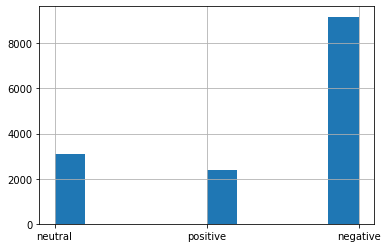

In [6]:
df['airline_sentiment'].hist()

In [7]:
df = df[df['airline_sentiment'] != 'neutral'].copy()
df

,airline_sentiment,text
1,positive,@VirginAmerica plus you've added commercials t...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...
5,negative,@VirginAmerica seriously would pay $30 a fligh...
6,positive,"@VirginAmerica yes, nearly every time I fly VX..."
...,...,...
14633,negative,@AmericanAir my flight was Cancelled Flightled...
14634,negative,@AmericanAir right on cue with the delays👌
14635,positive,@AmericanAir thank you we got on a different f...
14636,negative,@AmericanAir leaving over 20 minutes Late Flig...


In [8]:
target_map = {'positive': 1, 'negative': 0}
df['target'] = df['airline_sentiment'].map(target_map)
df

,airline_sentiment,text,target
1,positive,@VirginAmerica plus you've added commercials t...,1
3,negative,@VirginAmerica it's really aggressive to blast...,0
4,negative,@VirginAmerica and it's a really big bad thing...,0
5,negative,@VirginAmerica seriously would pay $30 a fligh...,0
6,positive,"@VirginAmerica yes, nearly every time I fly VX...",1
...,...,...,...
14633,negative,@AmericanAir my flight was Cancelled Flightled...,0
14634,negative,@AmericanAir right on cue with the delays👌,0
14635,positive,@AmericanAir thank you we got on a different f...,1
14636,negative,@AmericanAir leaving over 20 minutes Late Flig...,0


In [10]:
df_train, df_test = train_test_split(df, random_state=42)

In [11]:
vectorizer = TfidfVectorizer(max_features=2000)
X_train = vectorizer.fit_transform(df_train['text'])
X_test = vectorizer.transform(df_test['text'])

In [14]:
X_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [15]:
Y_train = df_train['target']
Y_test = df_test['target']

In [16]:
D = X_train.shape[1]

In [17]:
# build model
i = Input(shape=(D,))
x = Dense(1)(i)

model = Model(i, x)

In [18]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2000)]            0         
                                                                 
 dense (Dense)               (None, 1)                 2001      
                                                                 
Total params: 2,001
Trainable params: 2,001
Non-trainable params: 0
_________________________________________________________________


In [20]:
model.compile(
    loss=BinaryCrossentropy(from_logits=True),
    optimizer=Adam(learning_rate=0.01),
    metrics=['accuracy']
)

In [23]:
r = model.fit(
    X_train, Y_train,
    validation_data=(X_test, Y_test),
    epochs=40,
    batch_size=128,
)

Epoch 1/40
68/68 [==============================] - 2s 17ms/step - loss: 0.5016 - accuracy: 0.7920 - val_loss: 0.3962 - val_accuracy: 0.8049
Epoch 2/40
68/68 [==============================] - 0s 7ms/step - loss: 0.3750 - accuracy: 0.7969 - val_loss: 0.3385 - val_accuracy: 0.8202
Epoch 3/40
68/68 [==============================] - 0s 4ms/step - loss: 0.3217 - accuracy: 0.8192 - val_loss: 0.3022 - val_accuracy: 0.8413
Epoch 4/40
68/68 [==============================] - 0s 4ms/step - loss: 0.2847 - accuracy: 0.8447 - val_loss: 0.2765 - val_accuracy: 0.8607
Epoch 5/40
68/68 [==============================] - 0s 4ms/step - loss: 0.2573 - accuracy: 0.8645 - val_loss: 0.2579 - val_accuracy: 0.8766
Epoch 6/40
68/68 [==============================] - 0s 6ms/step - loss: 0.2365 - accuracy: 0.8811 - val_loss: 0.2442 - val_accuracy: 0.8881
Epoch 7/40
68/68 [==============================] - 0s 5ms/step - loss: 0.2200 - accuracy: 0.8925 - val_loss: 0.2334 - val_accuracy: 0.9012
Epoch 8/40
68/68 [=

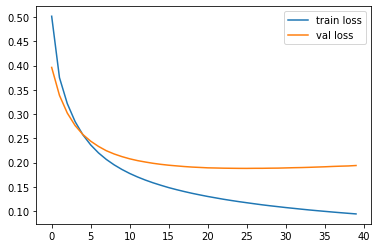

In [24]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend();

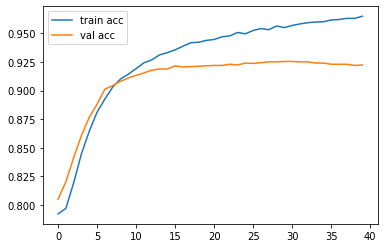

In [25]:
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend();

In [26]:
P_train = ((model.predict(X_train) > 0) * 1.0).flatten()
P_test = ((model.predict(X_test) > 0) * 1.0).flatten()

91/91 [==============================] - 0s 2ms/step


In [27]:
cm = confusion_matrix(Y_train, P_train, normalize='true')
cm

array([[0.99095551, 0.00904449],
       [0.09833333, 0.90166667]])

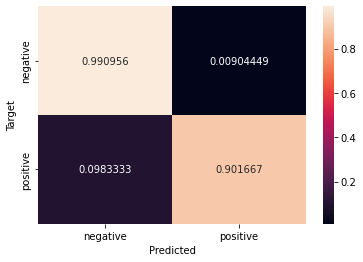

In [28]:
def plot_cm(cm):
    classes = ['negative', 'positive']
    df_cm = pd.DataFrame(cm, index=classes, columns=classes)
    ax = sn.heatmap(df_cm, annot=True, fmt='g')
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Target")
plot_cm(cm)

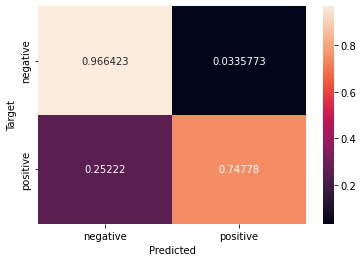

In [29]:
cm_test = confusion_matrix(Y_test, P_test, normalize='true')
plot_cm(cm_test)

In [30]:
Pr_train = model.predict(X_train)
Pr_test = model.predict(X_test)
print("Train AUC:", roc_auc_score(Y_train, Pr_train))
print("Test AUC:", roc_auc_score(Y_test, Pr_test))

91/91 [==============================] - 0s 1ms/step
Train AUC: 0.9950035659291677
Test AUC: 0.9547424817390998


In [31]:
print("Train F1:", f1_score(Y_train, P_train))
print("Test F1:", f1_score(Y_test, P_test))

Train F1: 0.9314203730272597
Test F1: 0.792843691148776


In [32]:
model.layers

In [33]:
model.layers[1].get_weights()

[array([[-3.7552197],
        [ 3.2893934],
        [-1.5816419],
        ...,
        [ 2.0332901],
        [ 1.6217917],
        [-2.9278595]], dtype=float32),
 array([-0.24591067], dtype=float32)]

In [34]:
w = model.layers[1].get_weights()[0]

In [35]:
word_index_map = vectorizer.vocabulary_
word_index_map

{'jetblue': 973,
 'thanks': 1726,
 'for': 753,
 'having': 855,
 'us': 1859,
 'hang': 838,
 'out': 1262,
 'at': 197,
 'tampa': 1708,
 'airport': 122,
 'forever': 756,
 'today': 1767,
 'it': 964,
 'really': 1420,
 'been': 243,
 'an': 147,
 'awesome': 217,
 'experience': 654,
 'americanair': 143,
 'was': 1898,
 'told': 1770,
 'you': 1993,
 'could': 452,
 'only': 1245,
 'refund': 1434,
 'me': 1107,
 'the': 1730,
 'cost': 448,
 'of': 1224,
 'my': 1179,
 'original': 1254,
 'return': 1476,
 'flight': 726,
 'note': 1211,
 'had': 828,
 'booked': 273,
 'more': 1164,
 'expensive': 653,
 'everyone': 635,
 'else': 602,
 'outstanding': 1267,
 'united': 1842,
 'denver': 516,
 'to': 1766,
 'austin': 207,
 'still': 1660,
 'on': 1239,
 'ground': 820,
 'issue': 961,
 'is': 959,
 'lack': 999,
 'announcement': 151,
 'made': 1086,
 'so': 1606,
 'late': 1010,
 'when': 1929,
 'gate': 793,
 'agent': 113,
 'there': 1734,
 'over': 1268,
 'hour': 897,
 'southwestair': 1626,
 'hold': 880,
 '30': 36,
 'min': 1141,


In [36]:
threshold = 2

print("Most positive words:")
word_weight_tuples = []
for word, index in word_index_map.items():
    weight = w[index, 0]
    if weight > threshold:
        word_weight_tuples.append((word, weight))
word_weight_tuples = sorted(word_weight_tuples, key=lambda x: -x[1])
for i in range(10):
    word, weight = word_weight_tuples[i]
    print(word, weight)

Most positive words:
thank 9.701105
thanks 9.383366
worries 8.392807
great 7.908227
awesome 7.382023
love 7.2628417
excellent 7.147784
kudos 6.72511
amazing 6.474794
best 6.1208262


In [37]:
print("Most negative words:")
word_weight_tuples = []
for word, index in word_index_map.items():
    weight = w[index, 0]
    if weight < -threshold:
        word_weight_tuples.append((word, weight))
word_weight_tuples = sorted(word_weight_tuples, key=lambda x: x[1])
for i in range(10):
    word, weight = word_weight_tuples[i]
    print(word, weight)

Most negative words:
worst -9.30695
paid -7.7392535
not -7.630643
rude -7.5773125
disappointed -7.2275257
nothing -6.7971263
website -6.766824
hung -6.6855736
instead -6.642881
list -6.2193403
